# Goal

This project is carried out to provide a recommendation system that will recommend new songs to users depend on which songs they have been listening to and liked. The dataset used is this project is derived from **Million Song Dataset** and can be found [here](http://millionsongdataset.com/tasteprofile/)

# Preprocessing the data

In [ ]:
count = 0
mylist = []
with open("/content/drive/MyDrive/train_triplets.txt", "r") as file1:
    for line in file1:
        if count <= 10000:
            mylist.append(line)
        count += 1

    #FileContent = file1.read()
    #print(FileContent)

In [ ]:
mylist[:10]

['b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOAKIMP12A8C130995\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOAPDEY12A81C210A9\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBBMDR12A8C13253B\t2\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBFNSP12AF72A0E22\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBFOVM12A58A7D494\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBNZDC12A6D4FC103\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBSUJE12A6D4F8CF5\t2\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBVFZR12A6D4F8AE3\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBXALG12A8C13C108\t1\n',
 'b80344d063b5ccb3212f76538f3d9e43d87dca9e\tSOBXHDL12A81C204C0\t1\n']

In [ ]:
# Writing to file
with open("data.txt", "w") as fp:
    fp.writelines(mylist)

# Loading libraries and preparing the data for modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data.txt", "\t", header=None, names=["user_id", "song_id", "listen_count"])

In [ ]:
df.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [ ]:
df.shape

(10001, 3)

In [ ]:
df["user_id"].nunique()

173

In [ ]:
df["song_id"].nunique()

7849

In [ ]:
df["listen_count"].nunique()

56

In [ ]:
df["listen_count"].unique()

array([  1,   2,   5,   6,   8,   3,  11,  15,   9,  10,   4,  13,  18,
        12,  16,   7,  26,  14,  23,  20,  17,  28,  19,  55,  52,  25,
        22, 126,  58,  35,  24,  77,  21,  61,  31,  69,  43,  32,  33,
        45,  64,  27,  39, 140, 111,  42,  38,  36,  29,  44,  46,  30,
        40,  41,  53,  79])

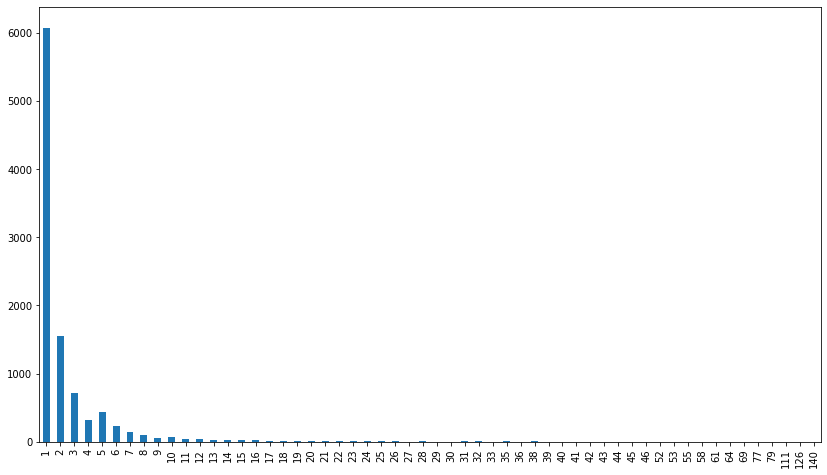

In [ ]:
df["listen_count"].value_counts().sort_index().plot.bar(figsize=(14,8))

In [ ]:
df.pivot(index='user_id', columns='song_id', values='listen_count')

song_id,SOAAAGQ12A8C1420C8,SOAADCB12A81C22AFA,SOAAFAC12A67ADF7EB,SOAARXR12A8C133D15,SOAATAD12A8C145609,SOAATLI12A8C13E319,SOAAUFG12A6D4FA966,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABBXP12AB018D0BC,SOABBYY12AB0181CB0,SOABHAD12AB0184B3F,SOABJBU12A8C13F63F,SOABJTC12A58A7DE0E,SOABNLP12A6D4F87F4,SOABNPM12A58A7943A,SOABRAB12A6D4F7AAF,SOABTPC12A67020F33,SOABTTR12A6D4FC2EB,SOABULH12A8C1331A4,SOACHXA12A58A7BE3E,SOACIPG12A8AE47E1C,SOACKIA12A6D4F73D7,SOACKNX12A6D4F7E6F,SOACLTN12A58A797B4,SOACPBY12A8C13FEF9,SOACTVC12A6D4F773E,SOACVKD12A6D4F8F01,SOACWYB12AF729E581,SOACYKU12A5891CC64,SOADFMR12A6701FB5F,SOADGAI12A6D4F64A3,SOADGFH12A8C143D89,SOADHXV12A8C13F8B3,SOADISH12AB018DFAC,SOADJQJ12A8C141D38,SOADKLF12AB0183BE5,SOADLAH12AB0180C3F,SOADMKP12A8C13BAA4,SOADMTV12A6701FA3F,...,SOZWOAM12AF72A0088,SOZWSNT12A58A7A76E,SOZWSPY12AB01850A7,SOZWVEH12A6D4F7C37,SOZWWTF12A8C1408E2,SOZWXZK12A58A79A8E,SOZXBGE12AB0181BCF,SOZXBIS12A8AE44A2E,SOZXEZV12A6D4F737F,SOZXHRK12AB0183F11,SOZXKDN12A6D4FBBFE,SOZXKIA12A6D4F861C,SOZXMXX12AB0182C93,SOZXNTL12AB0186E7A,SOZXPIT12A6702099C,SOZXQHF12A58A79168,SOZXQRQ12A6701C323,SOZXWCH12A6701E065,SOZXZRY12A6D4F74E4,SOZYBGN12A8C13A93C,SOZYDZR12A8C13F4F0,SOZYJCQ12A6310D8F3,SOZYOMV12AB01861BC,SOZYPRF12A6310F1B4,SOZYQIH12AB01844BB,SOZYSDT12A8C13BFD7,SOZYUGZ12A8AE472AC,SOZYYEK12AB0184F53,SOZZADK12A8C13B8D9,SOZZBDO12B0B80C5BA,SOZZHXI12A8C13BF7D,SOZZIOH12A67ADE300,SOZZISR12A6D4F9391,SOZZPSS12A6D4F3C71,SOZZRHE12A6702165F,SOZZUAQ12AC468E289,SOZZVFP12A8C140F14,SOZZVNT12AF729EBC9,SOZZWZV12A67AE140F,SOZZYAO12A6701FF36
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0152fcbd02b172a874c75a57a913f0f0109ba272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01655ae6bc52e29c9cd100a7dde4e9eeae5e4031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03c90bfd09151973863c4cadd5a749cd7982abc0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06b31818386e598017a475f8e349b3ca31ba3178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07caa920795cd4f20bfeeb0e192a5ddd9566ecdd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f84f5b5a5c5d1d9fb4866f6488e0d2661b54c192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
!pip install surprise==0.1

     |████████████████████████████████| 11.8 MB 54 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619404 sha256=e3f5dbe1b4b1cf97b9ffaa15204ae5cc142fc354a2df8380222f83f9ef6f34a0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold

In [ ]:
reader = Reader(rating_scale=(1, 79))

In [ ]:
data = Dataset.load_from_df(df[['user_id', 'song_id', 'listen_count']], reader)

# Random model

In [ ]:
# Create model object
random_model = NormalPredictor()

In [ ]:
# Train on data using cross-validation with k=5 folds, measuring the RMSE and MAE
model_random_results = cross_validate(random_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.4384  5.7461  5.2734  5.1752  5.7862  5.4839  0.2457  
MAE (testset)     3.0592  3.1628  3.2221  3.0796  3.0219  3.1091  0.0730  
Fit time          0.01    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


# User-User collaborative filtering

In [ ]:
# Create model object
userBased_model = KNNBasic(sim_options={'user_based': True})

In [ ]:
model_user_results = cross_validate(userBased_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.3668  5.3001  4.0028  4.9085  4.8205  4.6797  0.4501  
MAE (testset)     2.0926  2.1654  2.0227  2.0729  2.0981  2.0903  0.0460  
Fit time          0.01    0.00    0.01    0.00    0.00    0.01    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


# Item-Item collaborative filtering

In [ ]:
# Create model object
itemBased_model = KNNBasic(sim_options={'user_based': False})

In [ ]:
model_item_results = cross_validate(itemBased_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.5537  4.6676  5.4917  4.0392  3.9453  4.5395  0.5526  
MAE (testset)     1.9579  1.9123  2.0187  1.9023  1.9455  1.9473  0.0412  
Fit time          1.64    1.36    1.39    1.26    1.22    1.37    0.15    
Test time         0.10    0.09    0.09    0.19    0.10    0.11    0.04    


# Matrix Factorization

In [ ]:
# Create model object
matrix_model = SVD()

In [ ]:
model_matrix_results = cross_validate(matrix_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.1527  3.6442  4.1913  3.1318  4.7680  4.1776  0.7318  
MAE (testset)     1.8232  1.7294  1.7955  1.5960  1.7964  1.7481  0.0821  
Fit time          0.53    0.56    0.53    0.52    0.52    0.53    0.01    
Test time         0.01    0.02    0.01    0.01    0.01    0.01    0.00    


# Evaluating the models using **Precision** and **Recall**

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, list())
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [ ]:
# Make list of k values
K = [5, 10]

# Make list of models
models = [random_model, userBased_model, itemBased_model, matrix_model]
model_names = ['model_random', 'model_user', 'model_item', 'model_matrix']

# Create k-fold cross validation object
kf = KFold(n_splits=5)

for k in K:
    for i, model in enumerate(models):
        print(f'>>> k={k}, model={model_names[i]}')
        # Run folder and take average
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('>>> precision:', round(sum(p) / len(p), 3))
        print('>>> recall  :', round(sum(r) / len(r), 3))
        print('\n')

>>> k=5, model=model_random
>>> precision: 0.297
>>> recall  : 0.599


>>> k=5, model=model_user
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precision: 0.813
>>> recall  : 0.447


>>> k=5, model=model_item
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precision: 0.892
>>> recall  : 0.466


>>> k=5, model=model_matrix
>>> precision: 0.846
>>> recall  

Comparing the precision and recall, Item-item collaborative filtering is performing the best on the dataset for recommendation.

# Prediction of Top-N for each user

In [ ]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 5.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [ ]:
for i, model in enumerate(models):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print the first one
    user = list(top_n.keys())[0]
    print(f'model name: {model_names[i]}')
    print(f'user ID: {user}')
    print(f'top 5 songs ID\'s this user would like, sorted by rating highest to lowest: \n{top_n[user]}')
    print('\n')

model name: model_random
user ID: b80344d063b5ccb3212f76538f3d9e43d87dca9e
top 5 song ID's this user would like, sorted by rating highest to lowest: 
[('SOXEJPL12AF72A138D', 18.070319874536395), ('SOCHEIM12AB0183177', 18.054058875435913), ('SOVJVXR12A6701C0C8', 17.71929481864201), ('SOSSCKD12AB0183197', 17.046786006839618), ('SOTRMQC12AB0181429', 16.96711619025923)]


Computing the msd similarity matrix...
Done computing similarity matrix.
model name: model_user
user ID: b80344d063b5ccb3212f76538f3d9e43d87dca9e
top 5 song ID's this user would like, sorted by rating highest to lowest: 
[('SOURSIU12A8C140B9A', 77.0), ('SOWOFQE12A6D4F9045', 64.0), ('SONHJCF12A58A795EC', 45.0), ('SOPUCYA12A8C13A694', 42.99999999999999), ('SOLYJZI12A6701F8F4', 33.0)]


Computing the msd similarity matrix...
Done computing similarity matrix.
model name: model_item
user ID: b80344d063b5ccb3212f76538f3d9e43d87dca9e
top 5 song ID's this user would like, sorted by rating highest to lowest: 
[('SOPABZM12A6D4FC668